In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import random
from tqdm.notebook import tqdm
from random import choice

from kaggle_environments import evaluate, make, utils

Loading environment lux_ai_s2 failed: No module named 'vec_noise'


In [2]:
env = make("connectx", debug=True)
out = env.render(mode="ansi")
print(out)

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+



# Q-table class

In [3]:
class QTable:
    
    def __init__(self, env):
        self.table = dict()
        self.n_actions = env.configuration.columns

    def add_item(self, state_key):
        self.table[state_key] = list(np.zeros(self.n_actions))
        
    def state_key(self, observation):
        board = observation.board[:] # Copy
        board.append(observation.mark)
        state_key = hex(int(''.join(np.array(observation.board).astype(str)), 3))[2:]
        return state_key

    def __call__(self, observation):
        state_key = self.state_key(observation)
        if state_key not in self.table:
            self.add_item(state_key)

        return self.table[state_key]

# My Agent

In [19]:
class Q_Agent:
    
    def __init__(self, env, q_table=None):
        if q_table is not None:
            self.q_table = q_table
        else:
            self.q_table = QTable(env)
        
    def __call__(self, observation, configuration):
        
        state_key = self.q_table.state_key(observation)

        if state_key not in self.q_table.table.keys():
            return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

        row = q_table(observation)[:] # Copy
        selected_items = []
        for j in range(q_table.n_actions):
            if observation.board[j] == 0:
                selected_items.append(row[j])
            else:
                selected_items.append(-1e7)

        action = int(np.argmax(selected_items))

        return action        

# Plot training summary

In [46]:
def plot_training_summary(summary):
    
    all_avg_rewards, all_qtable_rows, all_epsilons = summary

    fig, axs = plt.subplots(3, 1, figsize=(8, 6))
    fig.suptitle('Training summary')
    _ = axs[0].plot(all_avg_rewards)
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Avg rewards per round')
    axs[0].grid()

    _ = axs[1].plot(all_qtable_rows)
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Explored states')
    axs[1].grid()

    _ = axs[2].plot(all_epsilons)
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Epsilon')
    axs[2].grid()

    plt.tight_layout()

# Train Agent

In [49]:
def train_competing_q_agents(
    env,
    q_agent_1,
    q_agent_2,
    num_rounds=1000, # number of times one agent will be trained against the other, then they switch
    episodes_per_round=10,
    alpha=0.1,
    gamma=0.6,
    epsilon=0.99,
    min_epsilon=0.1,
    alpha_decay_step=1000,
    alpha_decay_rate=0.9,
    epsilon_decay_rate=0.9999,
):
    agent_1_avg_rewards_per_round   = [] 
    agent_1_qtable_rows             = []
    agent_1_epsilons                = []

    agent_2_avg_rewards_per_round   = [] 
    agent_2_qtable_rows             = []
    agent_2_epsilons                = []
    
    q_agents = [q_agent_1, q_agent_2]
     
    for r in tqdm(range(num_rounds)):
        
        if r > 0 and r % 2 == 0:
            epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)        
        
        q_agent = q_agents[0]
        trainer = env.train([None, q_agents[1]])
        
        for i in range(episodes_per_round):
            observation = trainer.reset()

            total_rewards = 0
            done = False

            while not done:
                if random.uniform(0, 1) < epsilon:
                    action = choice([c for c in range(env.configuration.columns) if observation.board[c] == 0])
                else:
                    action = q_agent(observation, env.configuration)

                next_observation, reward, done, info = trainer.step(action)

                # Reward rules
                if done:
                    if reward == 1: # Won
                        reward = 20
                    elif reward == 0: # Lost
                        reward = -20
                    else: # Draw
                        reward = 10
                else:
                    reward = -0.05 # Try to prevent the agent from taking a long move

                old_value = q_agent.q_table(observation)[action]
                next_max = np.max(q_agent.q_table(next_observation))

                # Update Q-value
                new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
                q_agent.q_table(observation)[action] = new_value

                observation = next_observation
                total_rewards += reward

        if r % 2 == 0:
            agent_1_avg_rewards_per_round.append(total_rewards/episodes_per_round)
            agent_1_qtable_rows.append(len(q_agent.q_table.table))
            agent_1_epsilons.append(epsilon)
        else:
            agent_2_avg_rewards_per_round.append(total_rewards/episodes_per_round)
            agent_2_qtable_rows.append(len(q_agent.q_table.table))
            agent_2_epsilons.append(epsilon)

        # switch agents
        q_agents = q_agents[::-1]
        
        if (r+1) % alpha_decay_step == 0:
            alpha *= alpha_decay_rate
           
    agent_1_summary = agent_1_avg_rewards_per_round, agent_1_qtable_rows, agent_1_epsilons
    agent_2_summary = agent_2_avg_rewards_per_round, agent_2_qtable_rows, agent_2_epsilons
    
    return agent_1_summary, agent_2_summary

In [74]:
q_agent_1 = Q_Agent(env)
q_agent_2 = Q_Agent(env)

In [75]:
agent_1_summary, agent_2_summary = train_competing_q_agents(
    env, 
    q_agent_1, 
    q_agent_2,
    num_rounds=1,
    episodes_per_round=10000,
    alpha=0.5,
    gamma=0.9,
    epsilon=0.3,
    min_epsilon=0.1,
    alpha_decay_step=1000,
    alpha_decay_rate=0.9,
    epsilon_decay_rate=0.9999,
)

  0%|          | 0/1 [00:00<?, ?it/s]

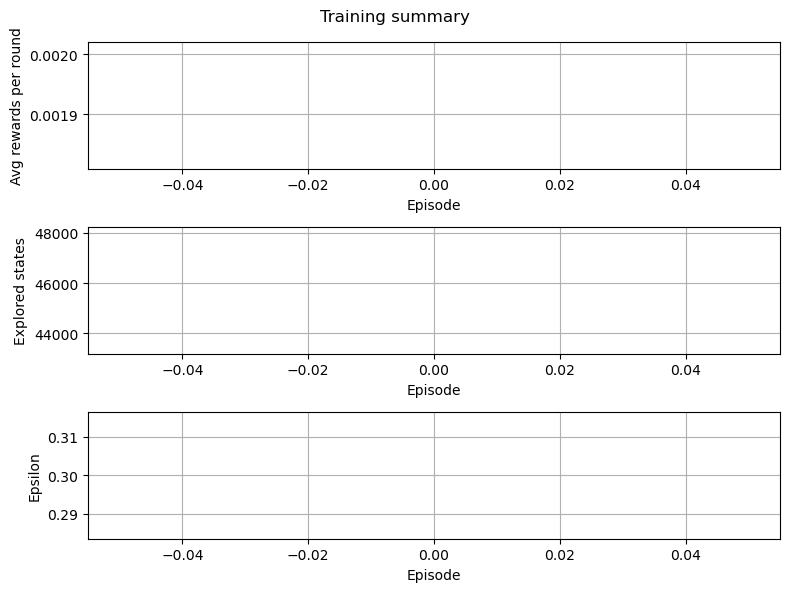

In [76]:
plot_training_summary(agent_1_summary)

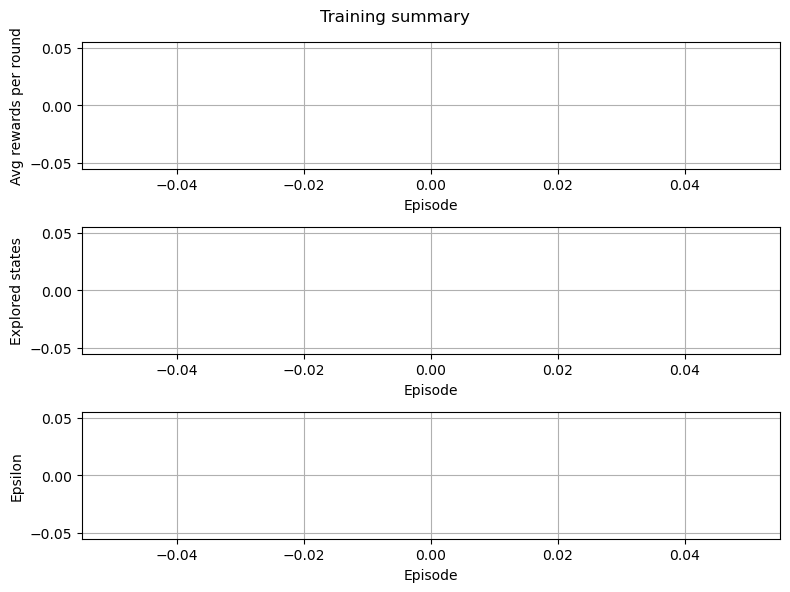

In [77]:
plot_training_summary(agent_2_summary)

# Play your Agent
Click on any column to place a checker there ("manually select action").

In [81]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([None, q_agent_1], width=500, height=450)

# Evaluate your Agent

In [82]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [q_agent_1, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [q_agent_1, "negamax"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [q_agent_1, q_agent_2], num_episodes=10)))

My Agent vs Random Agent: 0.4
My Agent vs Negamax Agent: -1.0
My Agent vs Negamax Agent: -0.2


In [83]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [q_agent_2, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [q_agent_2, "negamax"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [q_agent_2, q_agent_1], num_episodes=10)))

My Agent vs Random Agent: -0.2
My Agent vs Negamax Agent: -1.0
My Agent vs Negamax Agent: -0.2


In [78]:
alpha = 0.1
gamma = 0.6
epsilon = 0.99
min_epsilon = 0.1

episodes = 10000

alpha_decay_step = 1000
alpha_decay_rate = 0.9
epsilon_decay_rate = 0.9999
#----------------------------------------------

all_total_rewards = []
all_avg_rewards   = [] # Last 100 steps
all_qtable_rows   = []
all_epsilons      = []

q_table = QTable(env)

trainer = env.train([None, "random"])

for i in tqdm(range(episodes)):

    observation = trainer.reset()
    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)
    epochs, total_rewards = 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = choice([c for c in range(env.configuration.columns) if observation.board[c] == 0])
        else:
            row = q_table(observation)[:] # Copy
            selected_items = []
            for j in range(q_table.n_actions):
                if observation.board[j] == 0:
                    selected_items.append(row[j])
                else:
                    selected_items.append(-1e7)

            action = int(np.argmax(selected_items))

        next_observation, reward, done, info = trainer.step(action)

        # Apply new rules
        if done:
            if reward == 1: # Won
                reward = 20
            elif reward == 0: # Lost
                reward = -20
            else: # Draw
                reward = 10
        else:
            reward = -0.05 # Try to prevent the agent from taking a long move

        old_value = q_table(observation)[action]
        next_max = np.max(q_table(next_observation))

        # Update Q-value
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table(observation)[action] = new_value

        observation = next_observation
        epochs += 1
        total_rewards += reward

    all_total_rewards.append(total_rewards)
    avg_rewards = np.mean(all_total_rewards[max(0, i-100):(i+1)])
    all_avg_rewards.append(avg_rewards)
    all_qtable_rows.append(len(q_table.table))
    all_epsilons.append(epsilon)

    if (i+1) % alpha_decay_step == 0:
        alpha *= alpha_decay_rate        

  0%|          | 0/10000 [00:00<?, ?it/s]

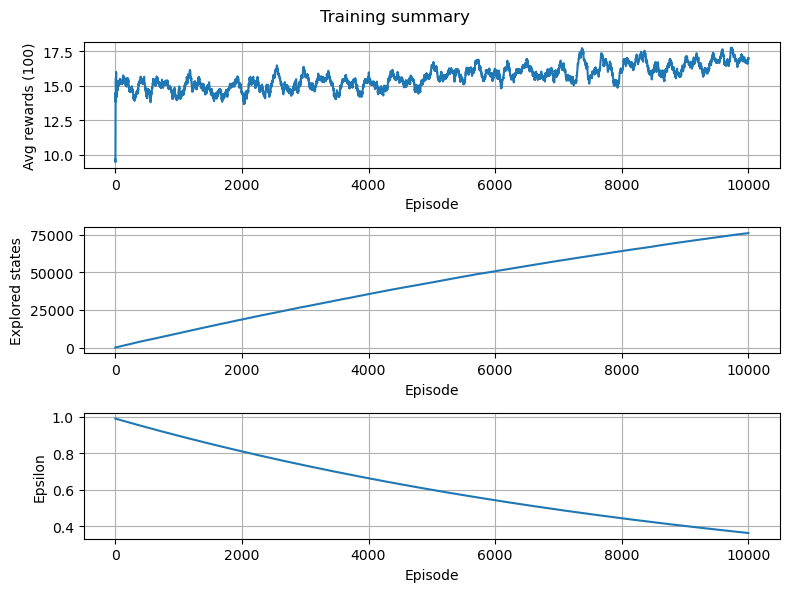

In [79]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
fig.suptitle('Training summary')
_ = axs[0].plot(all_avg_rewards)
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Avg rewards (100)')
axs[0].grid()

_ = axs[1].plot(all_qtable_rows)
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Explored states')
axs[1].grid()

_ = axs[2].plot(all_epsilons)
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Epsilon')
axs[2].grid()

plt.tight_layout()

# My Agent

In [6]:
def my_agent(observation, configuration):
    from random import choice

    board = observation.board[:] # Copy
    board.append(observation.mark)
    state_key = hex(int(''.join(np.array(board).astype(str)), 3))[2:]

    # if state_key not in q_table.keys(), pick random action
    if state_key not in q_table.table.keys():
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])
    
    row = q_table(observation)[:] # Copy
    selected_items = []
    for j in range(q_table.n_actions):
        if observation.board[j] == 0:
            selected_items.append(row[j])
        else:
            selected_items.append(-1e7)

    action = int(np.argmax(selected_items))

    return action

# Play your Agent
Click on any column to place a checker there ("manually select action").

In [84]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([None, my_agent], width=500, height=450)

# Evaluate your Agent

In [88]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

My Agent vs Random Agent: -0.3
My Agent vs Negamax Agent: -1.0


# Create an Agent

In [ ]:
tmp_dict_q_table = q_table.table.copy()
dict_q_table = dict()

for k in tmp_dict_q_table:
    if np.count_nonzero(tmp_dict_q_table[k]) > 0:
        dict_q_table[k] = int(np.argmax(tmp_dict_q_table[k]))

In [ ]:
my_agent = '''def my_agent(observation, configuration):
    from random import choice

    q_table = ''' \
    + str(dict_q_table).replace(' ', '') \
    + '''

    board = observation.board[:]
    board.append(observation.mark)
    state_key = list(map(str, board))
    state_key = hex(int(''.join(state_key), 3))[2:]

    if state_key not in q_table.keys():
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    action = q_table[state_key]

    if observation.board[action] != 0:
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    return action
    '''

In [ ]:
with open('submission.py', 'w') as f:
    f.write(my_agent)

# Play your Agent
Click on any column to place a checker there ("manually select action").

In [ ]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([None, "negamax"], width=500, height=450)

# Write Submission File

In [ ]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(my_agent, "submission.py")

# Submit Agent to Competition

In [ ]:
# !kaggle competitions submit -c connectx -f submission.py -m "My first submission"